# Aligned Baselines

Goal: investigate the agreement between integrated gradients and activation patching when the baselines are similar, across a variety of circuit tasks.

- Indirect Object Identification (Wang et al, 2023): consists of inputs like “When Mary and John went to the store, John gave a bottle of milk to”; models are expected to predict “Mary”. Performance measured using logit differences.

- Gender-Bias (Vig et al, 2020): designed to study gender bias in LMs. Gives models inputs like “The nurse said that”; biased models tend to complete this sentence with “she”. Performance measured using logit differences.

- Greater-Than (Hanna et al., 2023): models receive input like “The war lasted from the year 1741 to the year 17”, and must predict a valid two-digit end year, i.e. one that is greater than 41. Performance measured using probability differences.

- Capital–Country (Hanna et al., 2024): models receive input like “Tirana, the capital of” and must output the corresponding country (Albania). Corrupted instances contain another capital (e.g. Brasilia) instead. Performance measured using logit differences.

In [42]:
%load_ext autoreload
%autoreload 2

import torch
from torch import Tensor
from transformer_lens import HookedTransformer
from transformer_lens.utils import get_device

from attribution_methods import integrated_gradients, activation_patching, highlight_components
from testing import Task, TaskDataset, logit_diff_metric, greater_than_prob_diff_metric, average_correlation, measure_overlap, test_multi_ablated_performance, print_jaccard_multi
from plotting import plot_attn, plot_attn_comparison, plot_correlation, plot_correlation_comparison, plot_bar_chart

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
torch.set_grad_enabled(False)
torch.cuda.empty_cache()

device = get_device()
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

# Explicitly calculate and expose the result for each attention head
model.set_use_attn_result(True)
model.set_use_hook_mlp_in(True)

Loaded pretrained model gpt2-small into HookedTransformer


## Indirect Object Identification

### Case study

In [5]:
clean_input = "When John and Mary went to the store, John gave a bottle of milk to"
corrupted_input = "When John and Mary went to the store, Mary gave a bottle of milk to"
labels = torch.tensor([
    [model.to_tokens("Mary", prepend_bos=False).item(), 
     model.to_tokens("John", prepend_bos=False).item()]
])

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

Clean logit difference: tensor([3.5417], device='cuda:0')
Corrupted logit difference: tensor([-4.8407], device='cuda:0')


In [6]:
case_ap_mlp, case_ap_attn = activation_patching(model, clean_tokens, clean_logit_diff, corrupted_cache, corrupted_logit_diff, logit_diff_metric, labels)

torch.save(case_ap_mlp, "results/aligned/ioi/case_ap_mlp.pt")
torch.save(case_ap_attn, "results/aligned/ioi/case_ap_attn.pt")

Activation patching on attention heads in layer 0
Activation patching on MLP in layer 0
Activation patching on attention heads in layer 1
Activation patching on MLP in layer 1
Activation patching on attention heads in layer 2
Activation patching on MLP in layer 2
Activation patching on attention heads in layer 3
Activation patching on MLP in layer 3
Activation patching on attention heads in layer 4
Activation patching on MLP in layer 4
Activation patching on attention heads in layer 5
Activation patching on MLP in layer 5
Activation patching on attention heads in layer 6
Activation patching on MLP in layer 6
Activation patching on attention heads in layer 7
Activation patching on MLP in layer 7
Activation patching on attention heads in layer 8
Activation patching on MLP in layer 8
Activation patching on attention heads in layer 9
Activation patching on MLP in layer 9
Activation patching on attention heads in layer 10
Activation patching on MLP in layer 10
Activation patching on attenti

In [7]:
case_ig_mlp = torch.load("results/case_study/mlp_corrupt_clean.pt")
case_ig_attn = torch.load("results/case_study/attn_corrupt_clean.pt")

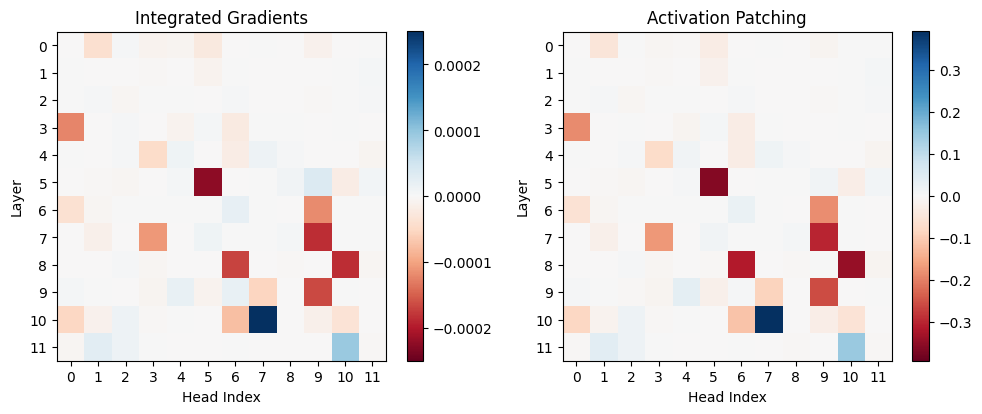

In [8]:
plot_attn_comparison(case_ig_attn[:1], case_ap_attn[:1], model)

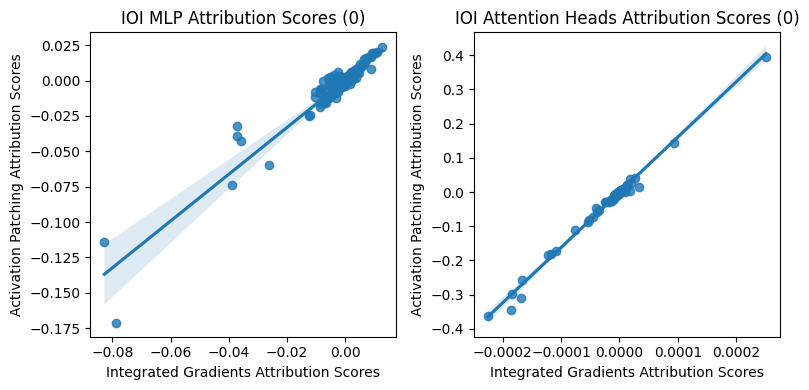

Correlation coefficient for neurons: 0.9520487991302581
Correlation coefficient for attention heads: 0.9952197197592786


In [9]:
plot_correlation_comparison(case_ig_mlp[:1], case_ap_mlp[:1], case_ig_attn[:1], case_ap_attn[:1], Task.IOI)

### Experiment

In [3]:
ioi_dataset = TaskDataset(Task.IOI)
ioi_dataloader = ioi_dataset.to_dataloader(batch_size=100)

clean_input, corrupted_input, labels = next(iter(ioi_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

Clean logit difference: tensor([-0.0307, -0.9269, -0.4937,  2.2320,  0.6754,  4.0447, -0.1785,  1.1947,
         1.1514,  1.7507,  0.1791,  4.2971,  2.9955, -0.7016, -2.1907, -3.5684,
        -4.4879, -1.2934, -3.8906, -0.6969, -0.8222,  0.0708,  0.2167,  4.4769,
         1.0375, -1.2644,  0.9309,  2.8114,  0.9975,  2.4103,  2.6244,  0.0125,
        -0.8472, -0.6130, -1.1623, -0.5109,  3.0073,  0.6154, -1.1229,  0.2680,
        -2.7379,  5.2855,  2.5019,  0.3219, -1.3112,  1.2942, -2.1428,  3.1053,
         1.6090,  3.1023,  1.8912,  0.4089,  4.0511,  2.5005,  3.5176, -1.5472,
         2.2213, -0.8523,  0.6682,  0.4244,  0.8053,  3.2905,  0.7295,  0.9946,
        -3.6073, -2.2671,  1.7894, -0.6390,  0.6320, -1.5326,  1.3206, -0.1224,
         0.1692,  1.9326,  3.1771,  1.1320, -0.0876,  3.1172,  2.3856,  3.2836,
        -2.0859,  3.6953,  2.8493, -2.4261,  1.1299,  0.1732, -1.4748, -2.1046,
        -0.6516, -0.6167,  0.0277, -1.7128,  0.6374,  2.6353, -1.4080,  3.2583,
         0.6919,

In [ ]:
ioi_ig_mlp, ioi_ig_attn = integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, logit_diff_metric, labels)

torch.save(ioi_ig_mlp, "results/aligned/ioi/ig_mlp.pt")
torch.save(ioi_ig_attn, "results/aligned/ioi/ig_attn.pt")

In [6]:
ioi_ap_mlp, ioi_ap_attn = activation_patching(model, clean_tokens, clean_logit_diff, corrupted_cache, corrupted_logit_diff, logit_diff_metric, labels)

torch.save(ioi_ap_mlp, "results/aligned/ioi/ap_mlp.pt")
torch.save(ioi_ap_attn, "results/aligned/ioi/ap_attn.pt")

Activation patching on attention heads in layer 0
Activation patching on MLP in layer 0
Activation patching on attention heads in layer 1
Activation patching on MLP in layer 1
Activation patching on attention heads in layer 2
Activation patching on MLP in layer 2
Activation patching on attention heads in layer 3
Activation patching on MLP in layer 3
Activation patching on attention heads in layer 4
Activation patching on MLP in layer 4
Activation patching on attention heads in layer 5
Activation patching on MLP in layer 5
Activation patching on attention heads in layer 6
Activation patching on MLP in layer 6
Activation patching on attention heads in layer 7
Activation patching on MLP in layer 7
Activation patching on attention heads in layer 8
Activation patching on MLP in layer 8
Activation patching on attention heads in layer 9
Activation patching on MLP in layer 9
Activation patching on attention heads in layer 10
Activation patching on MLP in layer 10
Activation patching on attenti

### Analysis

In [20]:
ioi_ig_mlp = torch.load("results/aligned/ioi/ig_mlp.pt")
ioi_ig_attn = torch.load("results/aligned/ioi/ig_attn.pt")
ioi_ap_mlp = torch.load("results/aligned/ioi/ap_mlp.pt")
ioi_ap_attn = torch.load("results/aligned/ioi/ap_attn.pt")

In [43]:
print_jaccard_multi(ioi_ig_mlp, ioi_ig_attn, ioi_ap_mlp, ioi_ap_attn)

Average Jaccard similarity score for MLP: 0.8971133232116699
Average Jaccard similarity score for Attention: 0.9473195672035217


In [51]:
ioi_ig_zero_mlp = torch.load("results/aligned/ioi/ig_zero_mlp.pt")
ioi_ig_zero_attn = torch.load("results/aligned/ioi/ig_zero_attn.pt")

print("For zero baseline:")
print_jaccard_multi(ioi_ig_zero_mlp, ioi_ig_zero_attn, ioi_ap_mlp, ioi_ap_attn)

For zero baseline:
Average Jaccard similarity score for MLP: 0.15522626042366028
Average Jaccard similarity score for Attention: 0.26444175839424133


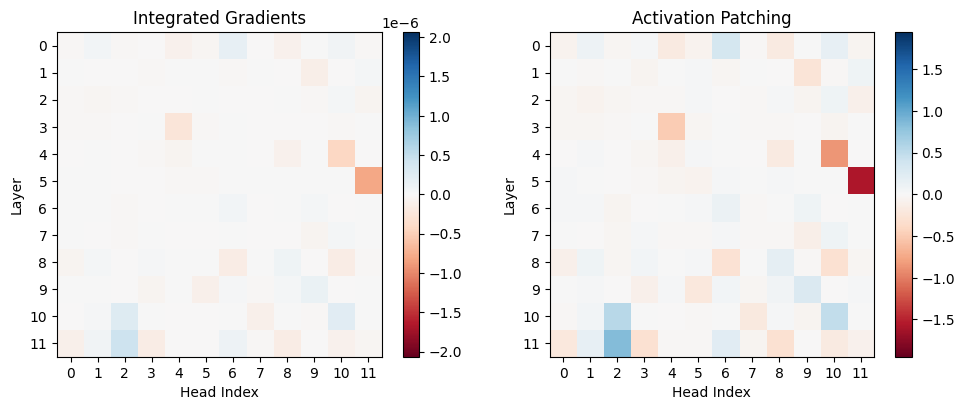

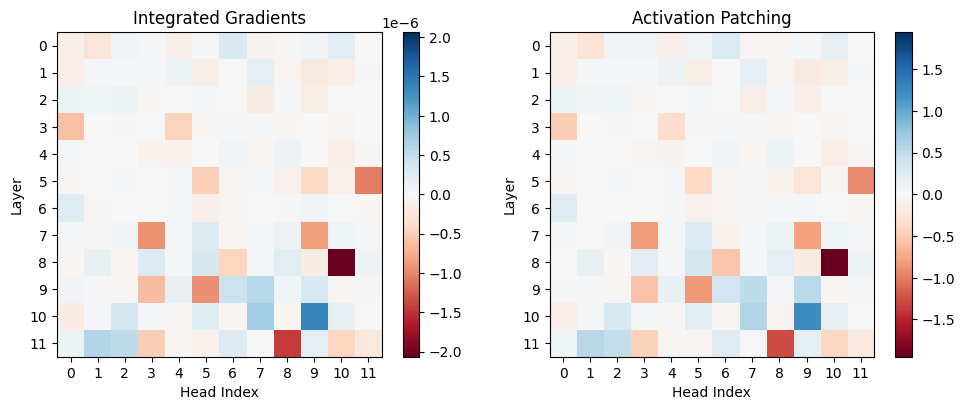

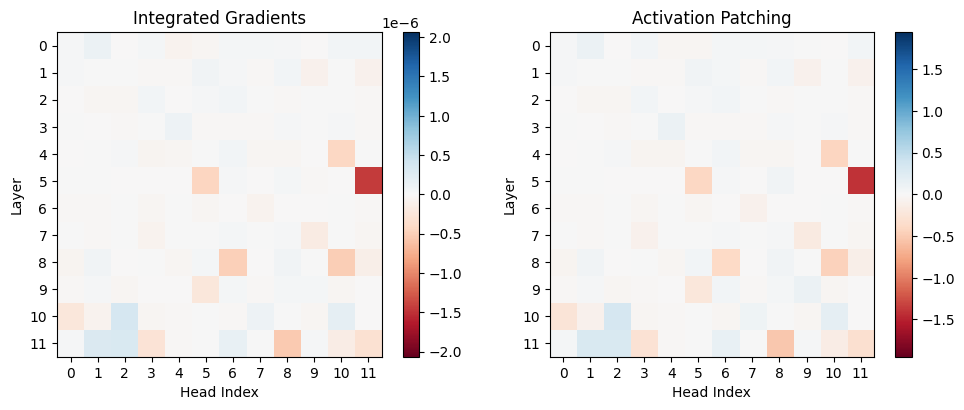

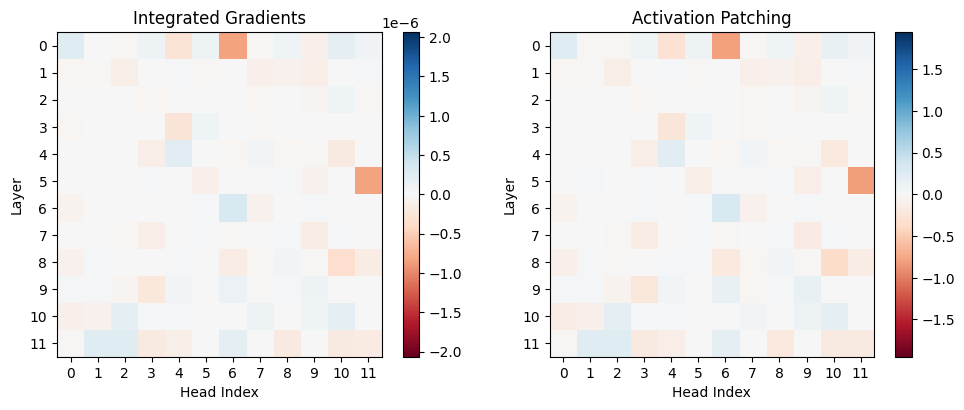

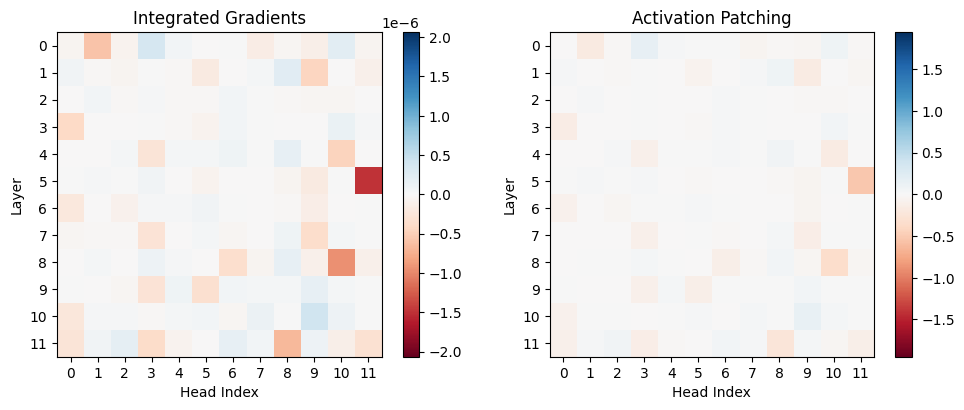

In [8]:
plot_attn_comparison(ioi_ig_attn[:5], ioi_ap_attn[:5], model)

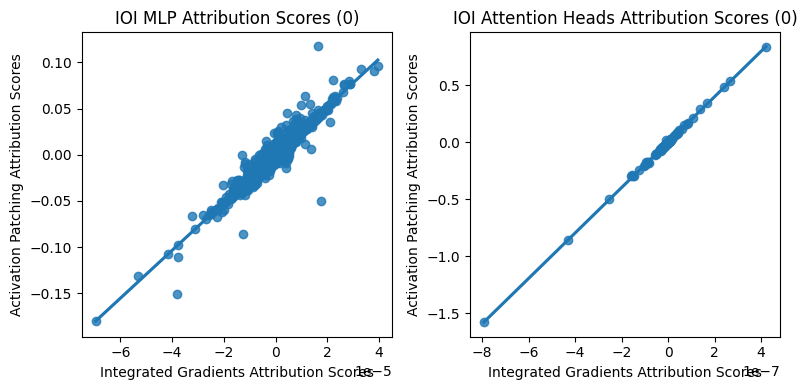

Correlation coefficient for neurons: 0.9781080393095625
Correlation coefficient for attention heads: 0.9996766519539676


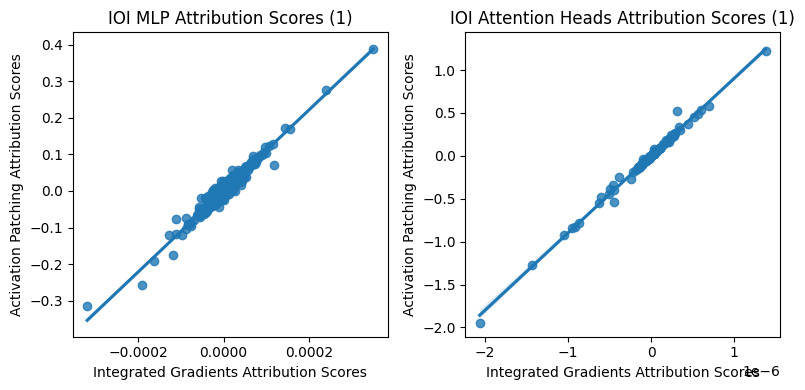

Correlation coefficient for neurons: 0.9806869207736839
Correlation coefficient for attention heads: 0.9951896333430784


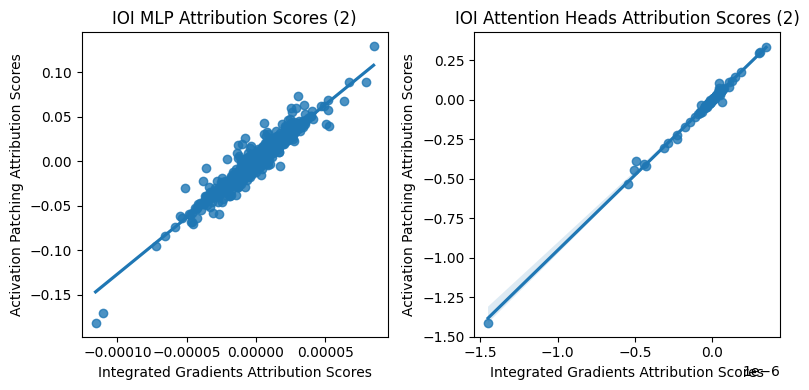

Correlation coefficient for neurons: 0.9757320311419594
Correlation coefficient for attention heads: 0.9967339352568454


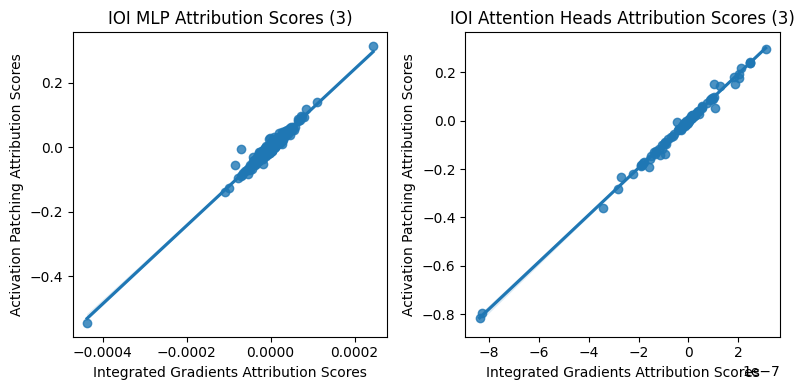

Correlation coefficient for neurons: 0.9839111497004037
Correlation coefficient for attention heads: 0.9967403119594924


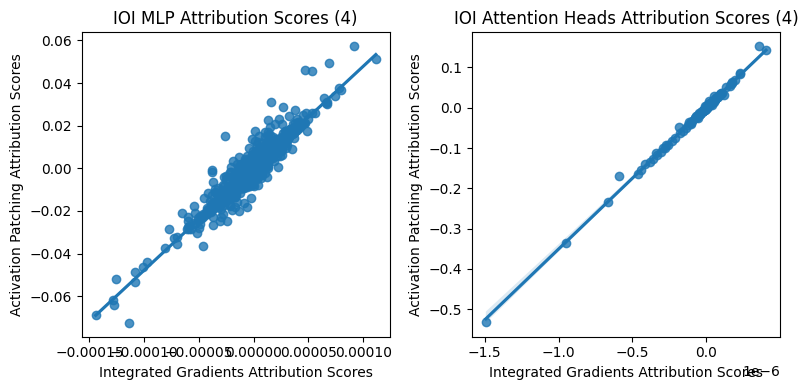

Correlation coefficient for neurons: 0.9670389843591409
Correlation coefficient for attention heads: 0.997777206804122


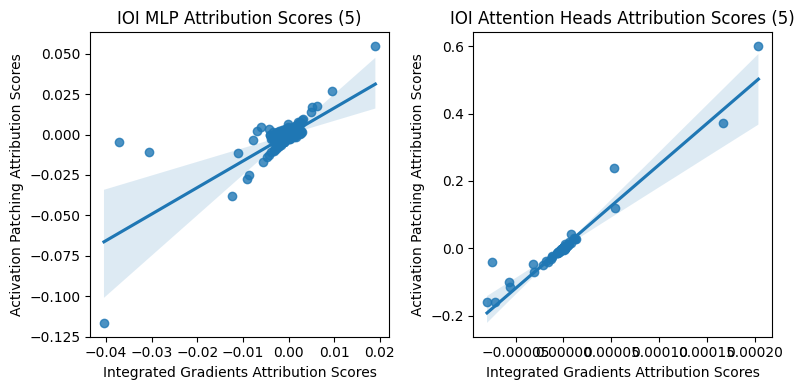

Correlation coefficient for neurons: 0.7595119694726896
Correlation coefficient for attention heads: 0.963231763268486


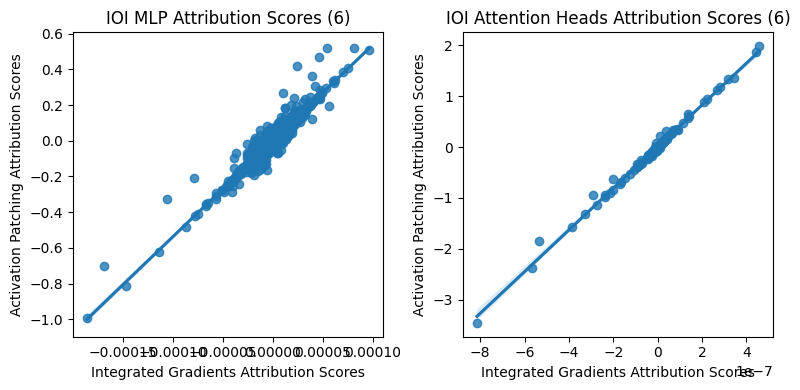

Correlation coefficient for neurons: 0.9741439068601965
Correlation coefficient for attention heads: 0.9965606172404634


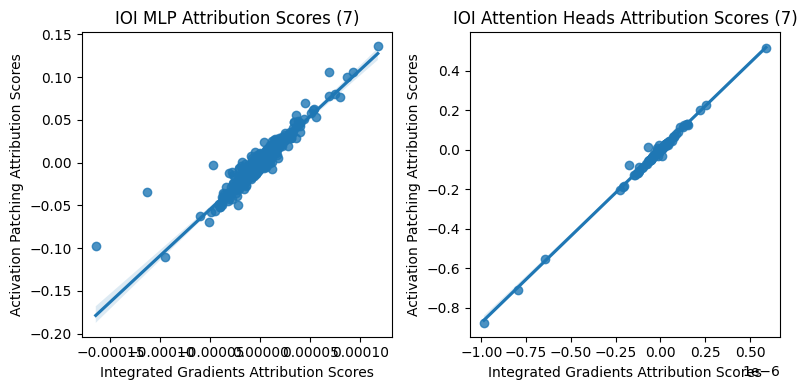

Correlation coefficient for neurons: 0.9665006507599821
Correlation coefficient for attention heads: 0.9964217682045792


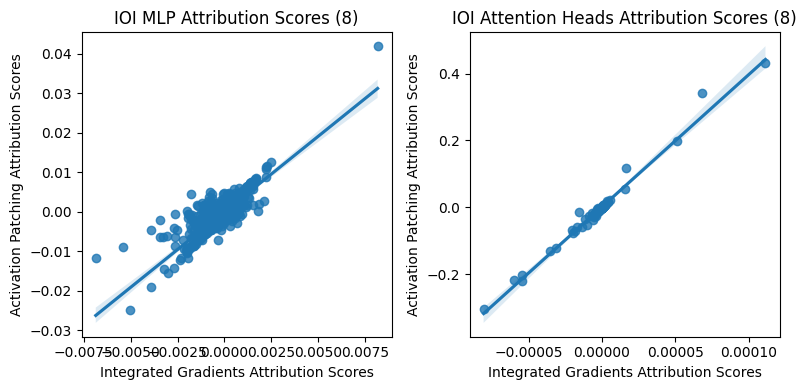

Correlation coefficient for neurons: 0.8802485892531234
Correlation coefficient for attention heads: 0.9904691626179392


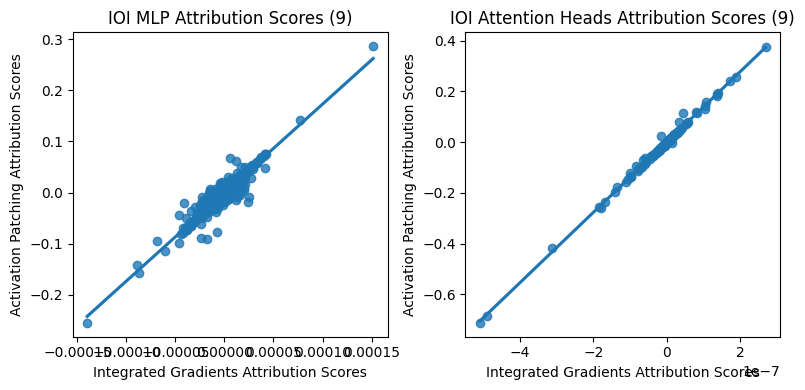

Correlation coefficient for neurons: 0.9687053827582425
Correlation coefficient for attention heads: 0.9978241406180226
Average absolute correlation between IG and AP neurons for IOI: (0.7818885659407933, 0.5572793196006637)
Average absolute correlation between IG and AP attention heads for IOI: (0.8163633394644311, 0.5707158276465426)


In [5]:
plot_correlation_comparison(ioi_ig_mlp[:10], ioi_ap_mlp[:10], ioi_ig_attn[:10], ioi_ap_attn[:10], Task.IOI)

print(f"Average absolute correlation between IG and AP neurons for IOI: {average_correlation(ioi_ig_mlp, ioi_ap_mlp)}")
print(f"Average absolute correlation between IG and AP attention heads for IOI: {average_correlation(ioi_ig_attn, ioi_ap_attn)}")

## Greater-Than

### Experiment

In [ ]:
greater_than_dataset = TaskDataset(Task.GENDER_BIAS)
greater_than_dataloader = greater_than_dataset.to_dataloader(batch_size=100)

clean_input, corrupted_input, labels = next(iter(greater_than_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = greater_than_prob_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = greater_than_prob_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

In [ ]:
greater_than_ig_mlp, greater_than_ig_attn = integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, greater_than_prob_diff_metric, labels)

torch.save(greater_than_ig_mlp, "results/aligned/greater_than/ig_mlp.pt")
torch.save(greater_than_ig_attn, "results/aligned/greater_than/ig_attn.pt")

In [ ]:
greater_than_ap_mlp, greater_than_ap_attn = activation_patching(model, clean_tokens, clean_logit_diff, corrupted_cache, corrupted_logit_diff, greater_than_prob_diff_metric, labels)

torch.save(greater_than_ap_mlp, "results/aligned/greater_than/ap_mlp.pt")
torch.save(greater_than_ap_attn, "results/aligned/greater_than/ap_attn.pt")

### Analysis

In [41]:
greater_than_ig_mlp = torch.load("results/aligned/greater_than/ig_mlp.pt")
greater_than_ig_attn = torch.load("results/aligned/greater_than/ig_attn.pt")
greater_than_ap_mlp = torch.load("results/aligned/greater_than/ap_mlp.pt")
greater_than_ap_attn = torch.load("results/aligned/greater_than/ap_attn.pt")

In [44]:
print_jaccard_multi(greater_than_ig_mlp, greater_than_ig_attn, greater_than_ap_mlp, greater_than_ap_attn)

Average Jaccard similarity score for MLP: 0.6522613763809204
Average Jaccard similarity score for Attention: 0.9195833206176758


In [52]:
greater_than_ig_zero_mlp = torch.load("results/aligned/greater_than/ig_zero_mlp.pt")
greater_than_ig_zero_attn = torch.load("results/aligned/greater_than/ig_zero_attn.pt")

print("For zero baseline:")
print_jaccard_multi(greater_than_ig_zero_mlp, greater_than_ig_zero_attn, greater_than_ap_mlp, greater_than_ap_attn)

For zero baseline:
Average Jaccard similarity score for MLP: 0.19806398451328278
Average Jaccard similarity score for Attention: 0.4362235367298126


In [ ]:
# Jaccard similarity score
ioi_ig_mlp_highlights = [highlight_components(x)[0] for x in ioi_ig_mlp]
ioi_ig_attn_highlights = [highlight_components(x)[0] for x in ioi_ig_attn]
ioi_ap_mlp_highlights = [highlight_components(x)[0] for x in ioi_ap_mlp]
ioi_ap_attn_highlights = [highlight_components(x)[0] for x in ioi_ap_attn]

ioi_jaccard_mlp = torch.stack([measure_overlap(ig, ap) for ig, ap in zip(ioi_ig_mlp_highlights, ioi_ap_mlp_highlights)])
ioi_jaccard_attn = torch.stack([measure_overlap(ig, ap) for ig, ap in zip(ioi_ig_attn_highlights, ioi_ap_attn_highlights)])

print(f"Average Jaccard similarity score for MLP: {ioi_jaccard_mlp.mean()}")
print(f"Average Jaccard similarity score for Attention: {ioi_jaccard_attn.mean()}")

In [9]:
print(f"Average absolute correlation between IG and AP neurons for Greater-Than: {average_correlation(greater_than_ig_mlp, greater_than_ap_mlp)}")
print(f"Average absolute correlation between IG and AP attention heads for Greater-Than: {average_correlation(greater_than_ig_attn, greater_than_ap_attn)}")

Average absolute correlation between IG and AP neurons for Greater-Than: (0.8665504565661234, 0.05594827749981406)
Average absolute correlation between IG and AP attention heads for Greater-Than: (0.9932103418861212, 0.005654689176885511)


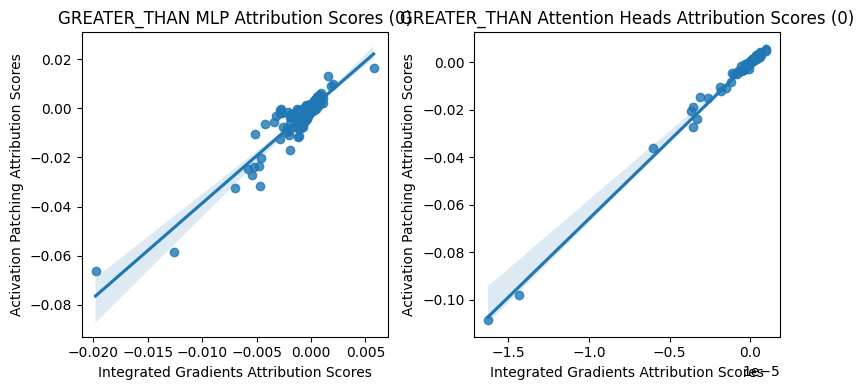

Correlation coefficient for neurons: 0.9221134366688721
Correlation coefficient for attention heads: 0.9965490130314656


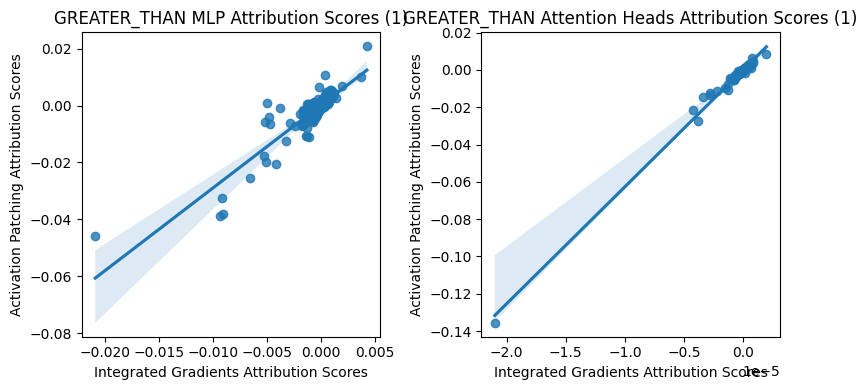

Correlation coefficient for neurons: 0.8871170520998005
Correlation coefficient for attention heads: 0.9944033712005587


KeyboardInterrupt: 

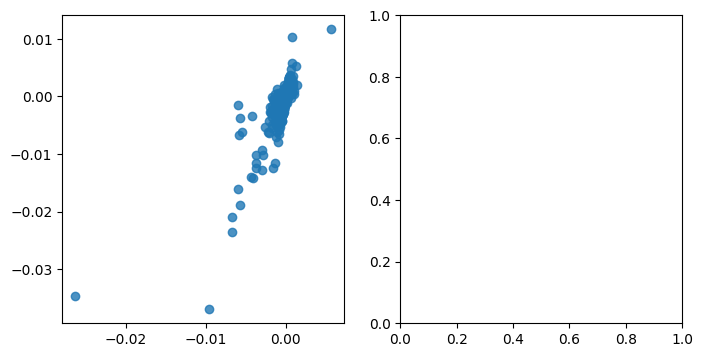

In [ ]:
plot_correlation_comparison(greater_than_ig_mlp, greater_than_ap_mlp, greater_than_ig_attn, greater_than_ap_attn, Task.GREATER_THAN)

In [16]:
# Test correlation of zero baselines
greater_than_ig_zero_mlp = torch.load("results/aligned/greater_than/ig_zero_mlp.pt")
greater_than_ig_zero_attn = torch.load("results/aligned/greater_than/ig_zero_attn.pt")

print(f"Average absolute correlation between IG and AP neurons for Greater-Than: {average_correlation(greater_than_ig_zero_mlp, greater_than_ap_mlp)}")
print(f"Average absolute correlation between IG and AP attention heads for Greater-Than: {average_correlation(greater_than_ig_zero_attn, greater_than_ap_attn)}")

Average absolute correlation between IG and AP neurons for Greater-Than: (0.11607216556929592, 0.06408352895996786)
Average absolute correlation between IG and AP attention heads for Greater-Than: (0.32199232252076687, 0.10492983156933004)


## Capital Country

### Experiment

In [ ]:
capital_country_dataset = TaskDataset(Task.CAPITAL_COUNTRY)
capital_country_dataloader = capital_country_dataset.to_dataloader(batch_size=100)

clean_input, corrupted_input, labels = next(iter(capital_country_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

In [ ]:
capital_country_ig_mlp, capital_country_ig_attn = integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, logit_diff_metric, labels)

torch.save(capital_country_ig_mlp, "results/aligned/capital_country/ig_mlp.pt")
torch.save(capital_country_ig_attn, "results/aligned/capital_country/ig_attn.pt")

In [ ]:
capital_country_ap_mlp, capital_country_ap_attn = activation_patching(model, clean_tokens, clean_logit_diff, corrupted_cache, corrupted_logit_diff, logit_diff_metric, labels)

torch.save(capital_country_ap_mlp, "results/aligned/capital_country/ap_mlp.pt")
torch.save(capital_country_ap_attn, "results/aligned/capital_country/ap_attn.pt")

### Analysis

In [10]:
capital_country_ig_mlp = torch.load("results/aligned/capital_country/ig_mlp.pt")
capital_country_ig_attn = torch.load("results/aligned/capital_country/ig_attn.pt")
capital_country_ap_mlp = torch.load("results/aligned/capital_country/ap_mlp.pt")
capital_country_ap_attn = torch.load("results/aligned/capital_country/ap_attn.pt")

In [45]:
print_jaccard_multi(capital_country_ig_mlp, capital_country_ig_attn, capital_country_ap_mlp, capital_country_ap_attn)

Average Jaccard similarity score for MLP: 0.8356907963752747
Average Jaccard similarity score for Attention: 0.9347222447395325


In [53]:
capital_country_ig_zero_mlp = torch.load("results/aligned/capital_country/ig_zero_mlp.pt")
capital_country_ig_zero_attn = torch.load("results/aligned/capital_country/ig_zero_attn.pt")

print("For zero baseline:")
print_jaccard_multi(capital_country_ig_zero_mlp, capital_country_ig_zero_attn, capital_country_ap_mlp, capital_country_ap_attn)

For zero baseline:
Average Jaccard similarity score for MLP: 0.15141287446022034
Average Jaccard similarity score for Attention: 0.2635221481323242


In [ ]:
plot_correlation_comparison(capital_country_ig_mlp, capital_country_ap_mlp, capital_country_ig_attn, capital_country_ap_attn, Task.CAPITAL_COUNTRY)

In [11]:

print(f"Average absolute correlation between IG and AP neurons for Capital-Country: {average_correlation(capital_country_ig_mlp, capital_country_ap_mlp)}")
print(f"Average absolute correlation between IG and AP attention heads for Capital-Country: {average_correlation(capital_country_ig_attn, capital_country_ap_attn)}")

Average absolute correlation between IG and AP neurons for Capital-Country: (0.7397002317071489, 0.5742513357431775)
Average absolute correlation between IG and AP attention heads for Capital-Country: (0.7956251019273368, 0.5983751768773173)


In [15]:
# Test correlation of zero baselines
capital_country_ig_zero_mlp = torch.load("results/aligned/capital_country/ig_zero_mlp.pt")
capital_country_ig_zero_attn = torch.load("results/aligned/capital_country/ig_zero_attn.pt")

print(f"Average absolute correlation between IG and AP neurons for Capital-Country: {average_correlation(capital_country_ig_zero_mlp, capital_country_ap_mlp)}")
print(f"Average absolute correlation between IG and AP attention heads for Capital-Country: {average_correlation(capital_country_ig_zero_attn, capital_country_ap_attn)}")

Average absolute correlation between IG and AP neurons for Capital-Country: (0.03728049683453657, 0.07621704883860163)
Average absolute correlation between IG and AP attention heads for Capital-Country: (0.09178617902755994, 0.12523899564260976)


## Gender Bias

### Experiment

In [ ]:
gender_bias_dataset = TaskDataset(Task.GENDER_BIAS)
gender_bias_dataloader = gender_bias_dataset.to_dataloader(batch_size=100)

clean_input, corrupted_input, labels = next(iter(gender_bias_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

In [ ]:
gender_bias_ig_mlp, gender_bias_ig_attn = integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, logit_diff_metric, labels)

torch.save(gender_bias_ig_mlp, "results/aligned/gender_bias/ig_mlp.pt")
torch.save(gender_bias_ig_attn, "results/aligned/gender_bias/ig_attn.pt")

In [ ]:
gender_bias_ap_mlp, gender_bias_ap_attn = activation_patching(model, clean_tokens, clean_logit_diff, corrupted_cache, corrupted_logit_diff, logit_diff_metric, labels)

torch.save(gender_bias_ap_mlp, "results/aligned/gender_bias/ap_mlp.pt")
torch.save(gender_bias_ap_attn, "results/aligned/gender_bias/ap_attn.pt")

### Analysis

In [46]:
gender_bias_ig_mlp = torch.load("results/aligned/gender_bias/ig_mlp.pt")
gender_bias_ig_attn = torch.load("results/aligned/gender_bias/ig_attn.pt")
gender_bias_ap_mlp = torch.load("results/aligned/gender_bias/ap_mlp.pt")
gender_bias_ap_attn = torch.load("results/aligned/gender_bias/ap_attn.pt")

In [47]:
print_jaccard_multi(gender_bias_ig_mlp, gender_bias_ig_attn, gender_bias_ap_mlp, gender_bias_ap_attn)

Average Jaccard similarity score for MLP: 0.8321148753166199
Average Jaccard similarity score for Attention: 0.9361111521720886


In [54]:
gender_bias_ig_zero_mlp = torch.load("results/aligned/gender_bias/ig_zero_mlp.pt")
gender_bias_ig_zero_attn = torch.load("results/aligned/gender_bias/ig_zero_attn.pt")
print("For zero baseline:")
print_jaccard_multi(gender_bias_ig_zero_mlp, gender_bias_ig_zero_attn, gender_bias_ap_mlp, gender_bias_ap_attn)

For zero baseline:
Average Jaccard similarity score for MLP: 0.16445152461528778
Average Jaccard similarity score for Attention: 0.45089948177337646


In [ ]:
plot_correlation_comparison(gender_bias_ig_mlp, gender_bias_ap_mlp, gender_bias_ig_attn, gender_bias_ap_attn, Task.GENDER_BIAS)

In [ ]:
print(f"Average absolute correlation between IG and AP neurons for Gender-Bias: {average_correlation(gender_bias_ig_mlp, gender_bias_ap_mlp)}")
print(f"Average absolute correlation between IG and AP attention heads for Gender-Bias: {average_correlation(gender_bias_ig_attn, gender_bias_ap_attn)}")

Average absolute correlation between IG and AP neurons for Gender-Bias: (0.9375869651914783, 0.04979989159623912)
Average absolute correlation between IG and AP attention heads for Gender-Bias: (0.9992144126061124, 0.0009275176026773261)


In [17]:
# Test correlation of zero baselines
gender_bias_ig_zero_mlp = torch.load("results/aligned/gender_bias/ig_zero_mlp.pt")
gender_bias_ig_zero_attn = torch.load("results/aligned/gender_bias/ig_zero_attn.pt")

print(f"Average absolute correlation between IG and AP neurons for Gender-Bias: {average_correlation(gender_bias_ig_zero_mlp, gender_bias_ap_mlp)}")
print(f"Average absolute correlation between IG and AP attention heads for Gender-Bias: {average_correlation(gender_bias_ig_zero_attn, gender_bias_ap_attn)}")

Average absolute correlation between IG and AP neurons for Gender-Bias: (0.2650676198942111, 0.2335257552429267)
Average absolute correlation between IG and AP attention heads for Gender-Bias: (0.3237903015239483, 0.22605416092109923)
